In [59]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import csv
import json
import random
from operator import itemgetter
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

import time

plt.style.use('ggplot')

%matplotlib notebook

In [60]:
path_org_data = 'data/original/'

In [61]:
class LinkPrediction(object):
    
    def __init__(self, data_path, df_merge_file, df_nodes_file, df_relations_file, emb_file, light_file, dark_file, test_set, result_path):
        self.__data_path         = data_path
        self.__df_relations_file = df_relations_file
        self.__df_nodes_file     = df_nodes_file
        self.__df_merge_file     = df_merge_file 
        self.__emb_file          = emb_file
        self.__light_file        = light_file
        self.__dark_file         = dark_file
        self.__result_path       = result_path
        self.__test_set          = test_set
        
        
        self.__merge_cols        = ['h','t','r','h_id','t_id', 'r_id']
        self.__merge_cols_names  = self.__merge_cols[:3]
        self.__merge_cols_ids    = self.__merge_cols[3:]
        self.__other_cols        = ['id', 'name']
        
        self.__load_files()
        self.__read_embeddings()
        self.__get_training_examples()
        
    def draw_pca_of_all_nodes(self):
        self.__label_all_node_embedding()
        self.__plot_pca (self.__labeled_emb, 'PCA-{}.png'.format(self.__emb_file))
        
    def train_model_cross_validation(self, solver, multi_class, C=1e5, cv = 10, sel_feat = False, ver = ''):
        
        lst_X = [i[:-1] for i in self.__lst_all]
            
        lst_Y = [i[-1:] for i in self.__lst_all]
        
        print('train_model_cross_validation| train_model| {} and {}'.format(len(lst_X[0]), len(lst_Y[0])))
        X_train, X_test, y_train, y_test = train_test_split(lst_X, lst_Y, test_size=0.3, random_state=0)
        print('train_model_cross_validation| train_model| X_train: {}, X_test: {}, y_train: {}, y_test:{}'.format(len(X_train), len(X_test), len(y_train), len(y_test)))
        
        y_train = np.asarray(y_train)
        
        self.logreg = LogisticRegression(C=C, solver=solver, multi_class=multi_class)
        y_score_lr = self.logreg.fit(X_train, np.ravel(y_train)).decision_function(X_test)
        
        scores = cross_val_score(self.logreg, X_train, np.ravel(y_train), cv=cv)
        print('train_model_cross_validation| scores: {}'.format(scores ))
        print("train_model_cross_validation| Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
#         y_score_lr = self.logreg.fit(X_train, y_train).decision_function(X_test)
        
        p, r, th = self.__precision_recall_curve(y_test ,y_score_lr, ver)  
        
        
        self.__AUC_ROC(y_test ,y_score_lr, ver)
        
        y_pred = self.logreg.predict(X_test)
        print('train_model_cross_validation| Accuracy of logistic regression classifier on test set: {:.2f}'.format(self.logreg.score(X_test, y_test)))
        confusionmatrix = confusion_matrix(y_test, y_pred)
        print(confusionmatrix)
        
        print(classification_report(y_test, y_pred))
        
    def test_dark_kinase(self, sel_feat):
        self.__get_dark_kinase_emb() # create lst_emb_dark_pathway
        self.__prepare_dark_emb() # create lst_dark_all
        test =  self.__test(self.__lst_dark_all, sel_feat) # uses lst_dark_all
        
    def evaluate_test_set(self, sel_feat):
        self.__load_test_set(self.__test_set)
        self.__get_test_set_emb(self.__df_test_set)
        self.__prepare_test_set_emb()
        test =  self.__test(self.__lst_test_set_all, sel_feat)
        
    def __prepare_test_set_emb(self):
        
        list_test_set_yes_emb = [ [i[1], i[2]] for i in self.__lst_test_set]
        self.__lst_test_set_all = list()
        for i in list_test_set_yes_emb:
            lst = list([])
            lst.extend(i[0])
            lst.append(i[1])
            self.__lst_test_set_all.append(lst)
        
        print('__prepare_test_set_emb| list of test set prepared {}'.format(len(self.__lst_test_set_all)))
        
    def __get_test_set_emb(self, df):
        err = 0
        self.__lst_test_set = list()
        
        for i in df.itertuples():
            try:
                indx = i[0]
                h_id = i[4]
                t_id = i[5]
                h_emb = self.__emb_dict[str(h_id)]
                t_emb = self.__emb_dict[str(t_id)]
                emb = np.multiply(h_emb, t_emb)
                self.__lst_test_set.append([indx, emb, 1])
            except KeyError :
                err+=1
        print('__get_test_set_emb| test set emb list : {} with {} number of errors.'.format(len(self.__lst_test_set), err))
        
    def __load_test_set(self, test_file):
        mcols = self.__merge_cols
        dtype = {mcols[0]:object, mcols[1]:object, mcols[2]:object, mcols[3]:int, mcols[4]:int, mcols[5]:int}
        self.__df_test_set     = pd.read_csv(self.__data_path + test_file ,dtype=dtype)
        print('__load_test_set: df_test_set: {}'.format(self.__df_test_set.shape))
        
    def generate_dict_possible_pairs(self):
        
        self.__get_df_dark_node()
        self.__get_df_pathway_node()
        self.__get_df_human_pathway_node()
        print('generate_dict_possible_pairs| df_dark_node: {}, self.__df_human_pathway_node: {}'.format(self.__df_dark_node.shape[0], self.__df_human_pathway_nodes.shape[0]))
        
        
        self.__dict_pp_id     = dict()
        self.__dict_ppid_emb  = dict()
        self.__dict_ppid_pred = dict()
        self.__dict_ppid_sig  = dict()
        
        index = 0
        
        for d in self.__df_dark_node.itertuples():
            dark_id = d[1]
            dark_emb = self.__emb_dict[str(d[1])]
            
            for p in self.__df_human_pathway_nodes.itertuples():
                if str(p[1]) in self.__emb_dict:
                    path_id  = p[1]
                    path_emb = self.__emb_dict[str(p[1])]
                    
                    self.__dict_pp_id[(dark_id, path_id)] = index
                    self.__dict_id_pp[index] = (dark_id, path_id)
                    self.__dict_ppid_emb[index]  = np.multiply(dark_emb, path_emb)
                    self.__dict_ppid_pred[index] = list()
                    self.__dict_ppid_sig[index] = 0
                    index+=1
        
        print('generate_dict_possible_pairs| self.__dict_pp_id: {}, self.__dict_ppid_emb: {}, self.__dict_ppid_pred: {}'
              .format(len(self.__dict_pp_id), len(self.__dict_ppid_emb),len(self.__dict_ppid_pred)))
        print()
        
    def get_prediction_for_all(self,path_org_data, gene_map_file, reactome_map_file, n_iter = 1, p = 0.5, alternative='two-sided', pvalue = 0.05):
        
        self.__path_org_data, self.__gene_map_file, self.__reactome_map_file = path_org_data, gene_map_file, reactome_map_file
        
        # generate id for each possible pairs
        self.generate_dict_possible_pairs()
        
        c=0
        # add prediction for each pair in dictionary
        dict_ppid_emb = self.__dict_ppid_emb
        for i in tqdm(range(n_iter)):
            for k in dict_ppid_emb:
                
                prediction = self.logreg.predict_proba([dict_ppid_emb[k]])
                self.__dict_ppid_pred[k].append(prediction)
        
        dict_pair_prob = dict()
        for i in self.__dict_ppid_pred:
            pair = self.__dict_id_pp[i]
            dict_pair_prob[pair] = self.__dict_ppid_pred[i]
        
        self.save_dict_to_csv(dict_pair_prob, self.__emb_file)
        
    def save_dict_to_csv(self, d, file_name):
        w = csv.writer(open(self.__data_path + self.__result_path + 'dict_pred_prob_{}'.format(file_name), "w"))
        for key, val in d.items():
            w.writerow([key, val])
    
    def statistical_significance_for_each_prediction(self,path_org_data, gene_map_file, reactome_map_file, n_iter = 1, p = 0.5, alternative='two-sided', pvalue = 0.05):
        
        self.__path_org_data, self.__gene_map_file, self.__reactome_map_file = path_org_data, gene_map_file, reactome_map_file
        
        # generate id for each possible pairs
        self.generate_dict_possible_pairs()
        
        c=0
        # add prediction for each pair in dictionary
        dict_ppid_emb = self.__dict_ppid_emb
        for i in tqdm(range(n_iter)):
            for k in dict_ppid_emb:
                
                prediction = self.logreg.predict([dict_ppid_emb[k]])
                if prediction == 1:
                    c+=1
                
#                 prob = self.logreg.predict_proba([v])
                self.__dict_ppid_pred[k].append(prediction[0])
        print('c: {}'.format(c))
        
        
        # test the significance
        dict_ppid_pred = self.__dict_ppid_pred
        for k in dict_ppid_pred:
            success = dict_ppid_pred[k].count(1)
            
            if binom_test(success,n_iter,p = p, alternative = alternative) < pvalue:
                self.__dict_ppid_sig[k] = 1
                
        
        return self.__dict_ppid_sig.values()
        
    def predict_dark_pathway(self, df_all_merge, path_org_data, gene_map_file, reactome_map_file):
        
        
        self.__path_org_data, self.__gene_map_file, self.__reactome_map_file = path_org_data, gene_map_file, reactome_map_file

        self.__get_df_dark_node()
        df_dark_node = self.__df_dark_node
        
        # after changing to train-test split we need to predict using merge_all
        # self.__get_df_pathway_node()
        # self.__get_df_human_pathway_node()
        print('predict_dark_pathway| prediction process for train-test split...')
        mcols = self.__merge_cols
        dtype = {mcols[0]:object, mcols[1]:object, mcols[2]:object, mcols[3]:int, mcols[4]:int, mcols[5]:int}
        df_all_merge = pd.read_csv(self.__data_path + df_all_merge ,dtype=dtype)
        print('predict_dark_pathway| df_all_merge: {}'.format(df_all_merge.shape))
        
        df_p = df_all_merge[df_all_merge[mcols[2]] == 'hasPathway']
        print('predict_dark_pathway| df_p: {}'.format(df_p.shape))
        

        list_unique_pathway = list(df_p[mcols[1]].unique())
        

        print('predict_dark_pathway| list_unique_pathway: {}'.format(len(list_unique_pathway)))
        
        cols = self.__other_cols        
        df_pathway_node = self.__df_nodes[self.__df_nodes[cols[1]].isin(list_unique_pathway)]
               
        print('predict_dark_pathway| df_pathway_node: {}'.format(df_pathway_node.shape[0])) 

        
        dict_reactome_ALL_name, dict_reactome_HSA_name = self.__generate_reactome_to_name(self.__path_org_data, self.__reactome_map_file)
        print('predict_dark_pathway| dict_reactome_ALL_name: {}, dict_reactome_HSA_name: {}'.format(len(dict_reactome_ALL_name), len(dict_reactome_HSA_name)))
        list_HSA      = list(dict_reactome_HSA_name.keys())
        list_HSA_code = [i[i.rindex('-')+1:] for i in list_HSA]
        print('predict_dark_pathway| list_HSA: {}, list_HSA_code: {}'.format(len(list_HSA), len(list_HSA_code)))

        df_human_pathway_nodes = df_pathway_node[df_pathway_node['name'].isin(list_HSA_code)]
        print('predict_dark_pathway| df_human_pathway_nodes: {}'.format(df_human_pathway_nodes.shape))
        
        print('predict_dark_pathway| Done prediction process for train-test split')
        
        #######################################################################
        
        
        
        print('__predict_dark_pathway| df_dark_node: {}, self.__df_human_pathway_node: {}'.format(df_dark_node.shape[0], df_human_pathway_nodes.shape[0]))
        
        result = []
        all_results_prob = []
        
        all_count = 0 
        predicted_false_count = 0
        predicted_true_count = 0
        
        cpro = 0
        cpath = 0
        
        for d in df_dark_node.itertuples(): 
            all_count+=1
            if str(d[1]) in self.__emb_dict:
                
                dark_emb = self.__emb_dict[str(d[1])]
                for p in df_human_pathway_nodes.itertuples() :
                    
                    if str(p[1]) in self.__emb_dict:
                        path_emb = self.__emb_dict[str(p[1])]
                        e = np.multiply(dark_emb, path_emb)
                        prediction = self.logreg.predict([e])
                        prob = self.logreg.predict_proba([e])
                        all_results_prob.append([d[2], p[2], prob[0][1]])
                        
                        if (prediction ==1):
                            result.append([d[2], p[2], prob])
                            predicted_true_count += 1
                        else:
                            predicted_false_count+=1
                    else:
                        cpath+=1
#                         print('__predict_dark_pathway| missing pathway id from emb: {}'.format(d[1]))
#                         break
            else:
#                 print('__predict_dark_pathway| missing protein id form emb: {}'.format(d[1]))
                cpro+=1
        print('__predict_dark_pathway| missing protein: {}, missing pathways: {}'.format(cpro, cpath))
        
#         return result , predicted_false_count, predicted_true_count
        print('__predict_dark_pathway| possitive predictions: {} (negative predictions: {})'.format(len(result), predicted_false_count))
        result.sort(key=lambda elem: elem[2][0][1], reverse=True)
        predict_results_list = [(i[0], i[1],i[2][0][1]) for i in result]
        predict_results_list = sorted(predict_results_list, key=itemgetter(2), reverse=True)
        
        print('__predict_dark_pathway| removing the known predictions...')
        cols = self.__merge_cols
        list_prediction_for_unknown = list()
        for i in predict_results_list:
            if (self.__df_dark_pathway[(self.__df_dark_pathway[cols[0]] == i[0]) & (self.__df_dark_pathway[cols[1]] == i[1])].shape[0] == 0):
                list_prediction_for_unknown.append(i)
        remained = len(predict_results_list) - len(list_prediction_for_unknown)
        print('__predict_dark_pathway| all prediction: {}, prediction for unkowns: {}, remained(known): {}'.format(len(predict_results_list), len(list_prediction_for_unknown), remained))
        
        self.__list_prediction_for_unknown = list_prediction_for_unknown
        self.__save_list_3cols(list_prediction_for_unknown, self.__emb_file)
        print('__predict_dark_pathway| Raw Predictions saved.')
        print()
                                            
        
        df_all_results_prob = pd.DataFrame(all_results_prob, columns=['protein', 'pathway', 'probability'])
        all_resutls_path_name = self.__data_path + self.__result_path + 'pred_all_prob_{}.csv'.format(self.__emb_file)
        df_all_results_prob.to_csv(all_resutls_path_name, index=False)
        print('__predict_dark_pathway| all predictions {} saved.'.format(df_all_results_prob.shape))
                                                 
        return pd.DataFrame(list_prediction_for_unknown, columns=['protein', 'pathway', 'probability']), predict_results_list
    
    def generating_full_prediction_list(self):
        df_prediction_raw_unkowns =pd.DataFrame(self.__list_prediction_for_unknown, columns=['protein','pathway', 'score'])
        print('generating_full_prediction_list| df_prediction_raw_unkowns: {}'.format(df_prediction_raw_unkowns.shape))
        
        dict_uniprot_to_genes                          = self.__generate_uniprot_to_kinbase(self.__path_org_data, self.__gene_map_file)
        dict_reactome_ALL_name, dict_reactome_HSA_name = self.__generate_reactome_to_name(self.__path_org_data, self.__reactome_map_file)
        
        list_prediction_with_name = []
        for i in df_prediction_raw_unkowns.itertuples():
            uniprot  = i[1]
            reactome = i[2]
            score    = i[3]
            
            protein_name =  dict_uniprot_to_genes[uniprot]
            pathway_name = ''
            try:
                pathway_name = dict_reactome_HSA_name['R-HSA-' + reactome]
            except:
                pathway_name = dict_reactome_ALL_name[reactome]
                
            list_prediction_with_name.append([uniprot, protein_name, reactome, pathway_name, score])
        
        self.__df_prediction_with_name = pd.DataFrame(list_prediction_with_name
                                                      , columns=['uniprot', 'protein_name', 'pathway_id', 'pathway_name', 'score'])
        print('generating_full_prediction_list| df_prediction_with_names: {}'.format(self.__df_prediction_with_name.shape))
        
        self.__df_prediction_with_name.to_csv(self.__data_path + self.__result_path + 'prediction_with_names_' + self.__emb_file + '.csv', index=False)
        print('generating_full_prediction_list| prediction with names saved.')
        
        
        return self.__df_prediction_with_name
    
    def __wrtie_map_to_json(self, d, mapping_file_name):
        for i in d:
            d[i] = list(d[i])
        self.__write_dict_to_json(d, self.__data_path + self.__result_path, mapping_file_name)
        
    
    def __write_dict_to_json(self, d, filepath, filename):
        with open(filepath + filename + '.txt', 'w') as file:
            file.write(json.dumps(d))
        
    def __generate_reactome_to_name(self, path_org_data, file_name):
        df_reactome = pd.read_csv(path_org_data + file_name, sep='\t', names=['id', 'identifier', 'name', 'a', 'b', 'c'])
        df_reactome_short = df_reactome[['identifier', 'a']].drop_duplicates(keep='first')
        print('__generate_reactome_to_name| df_reactome_short: {}'.format(df_reactome_short.shape))
        
        dict_reactome_HSA_name = dict()
        dict_reactome_ALL_name = dict()
        for i in df_reactome_short.itertuples():
            full_id = i[1]
            name    = i[2]
            if 'R-HSA' in full_id:
                if full_id not in dict_reactome_HSA_name:
                    dict_reactome_HSA_name[full_id] = set()
                dict_reactome_HSA_name[full_id].add(name)
                
            short_id = full_id[full_id.rindex('-')+1:]
            if short_id not in dict_reactome_ALL_name:
                dict_reactome_ALL_name[short_id] = set()                
            dict_reactome_ALL_name[short_id].add(name)
            
        print('__generate_reactome_to_name| dict_reactome_ALL_name: {}, dict_reactome_HSA_name: {}'.format(
            len(dict_reactome_ALL_name), len(dict_reactome_HSA_name)))
        mapping_file_name = 'reactometoid'
        self.__wrtie_map_to_json(dict_reactome_ALL_name, mapping_file_name)
        print('__generate_reactome_to_name| mapping file {}.txt is saved.'.format(mapping_file_name))
        
        return dict_reactome_ALL_name, dict_reactome_HSA_name
        
    def __generate_uniprot_to_kinbase(self, path_org_data, file_name):
        df_uniprot_to_gene = pd.read_csv(path_org_data + file_name, sep='\t')
        print('__generate_uniprot_to_kinbase| df_uniprot_to_gene: {}'.format(df_uniprot_to_gene.shape))

        unique_uniprot_from_uniprotIds = list(df_uniprot_to_gene['Entry'].unique())
        print('__generate_uniprot_to_kinbase| unique_uniprot_from_uniprotIds : %d'%len(unique_uniprot_from_uniprotIds))

        dict_uniprot_to_genes = dict()
        for i in df_uniprot_to_gene.itertuples():
            uniprot = i[1]
            Gene = i[2]
            if uniprot not in dict_uniprot_to_genes:
                dict_uniprot_to_genes[uniprot] = set()
            dict_uniprot_to_genes[uniprot].add(Gene)

        print('__generate_uniprot_to_kinbase| dict_uniprot_to_genes: %d'% len(dict_uniprot_to_genes))
        return dict_uniprot_to_genes
        
    
    def __load_files(self):
        mcols = self.__merge_cols
        dtype = {mcols[0]:object, mcols[1]:object, mcols[2]:object, mcols[3]:int, mcols[4]:int, mcols[5]:int}
        self.__df_merge     = pd.read_csv(self.__data_path + self.__df_merge_file ,dtype=dtype)
        self.__df_nodes     = pd.read_csv(self.__data_path + self.__df_nodes_file)
        self.__df_relations = pd.read_csv(self.__data_path + self.__df_relations_file)
            
        print('__load_files| df_merge: {}, df_nodes: {}, df_relations: {}'.format(self.__df_merge.shape, self.__df_nodes.shape
                                                                                  , self.__df_relations.shape))
        print()
        
    def __save_list_3cols(self, lst, file_name):
        with open(self.__data_path + self.__result_path + 'predictions_raw_{}.csv'.format(file_name), 'w') as fp:
            fp.write('\n'.join('%s,%s,%s' % x for x in lst))
    
    def __get_df_pathway(self):
        
        self.__df_pathway = self.__df_merge[self.__df_merge['r'] == 'hasPathway']
#         self.__df_pathway["t"]= self.__df_pathway["t"].astype(str)
        print('__get_df_pathway| pathway: {}'.format(self.__df_pathway.shape[0]))
        print()
        
    def __get_list_light_kinase(self):
        df_light = pd.read_csv(self.__data_path + self.__light_file + '.csv')
        df_light = df_light.rename(columns = {'uniprot':'id'})
        self.__df_light = df_light
        self.__list_light= list(self.__df_light['id'].unique())
        print('__get_list_light_kinase| light list: {}'.format(len(self.__list_light)))
        print()
        
    def __get_list_dark_kinase(self):
        df_dark = pd.read_csv(self.__data_path + self.__dark_file +'.csv') 
        df_dark = df_dark.rename(columns = {'uniprot':'id'})
        self.__df_dark = df_dark
        self.__list_dark = list(self.__df_dark['id'].unique())
        print('__get_list_dark_kinase| dark list: {}'.format(len(self.__list_dark)))
        print()
    
    def __split_dark_N_light(self):
        
        mcols = self.__merge_cols
        
        self.__get_df_pathway()
        self.__get_list_light_kinase()
        self.__get_list_dark_kinase()
        
        df_dark_pathway = self.__df_pathway[self.__df_pathway[mcols[0]].isin(self.__list_dark)]
        df_non_dark_pathway = self.__df_pathway[~self.__df_pathway[mcols[0]].isin(self.__list_dark)]

        print('__split_dark_N_light| dark: {}, Non-Dark:{}'.format(df_dark_pathway.shape, df_non_dark_pathway.shape))
        
        self.__df_dark_pathway     = df_dark_pathway
        self.__df_non_dark_pathway = df_non_dark_pathway
        print()
        
    def __create_unique_list(self):
        mcols = self.__merge_cols
        
        self.__list_unique_gene    = list(self.__df_pathway[mcols[3]].unique())
        self.__list_unique_pathway = list(self.__df_pathway[mcols[4]].unique())
        
        print('__create_unique_list| gene: {}, pathway:{}'.format(len(self.__list_unique_gene), len(self.__list_unique_pathway)))
        print()
        
    def __create_list_no(self):
        
        cols = self.__merge_cols
        
        self.__create_unique_list()
        
        self.__list_no  = list([])
        
        print('__create_list_no| df_non_dark_pathway.shape: {}, gene:{}, pathway: {}'.format(
            self.__df_non_dark_pathway.shape[0], len(self.__list_unique_gene), len(self.__list_unique_pathway) ))
        
        check_tup = set(tuple(zip(self.__df_non_dark_pathway[cols[3]], self.__df_non_dark_pathway[cols[4]])))
        
        print('__create_list_no| check_tup: {}'.format(len(check_tup)))
        
        for i in range(self.__df_non_dark_pathway.shape[0]):
            g = random.choice(self.__list_unique_gene)
            p = random.choice(self.__list_unique_pathway )
            if (str(p) in self.__emb_dict.keys() ) and (str(g) in self.__emb_dict.keys() ):  
                if ((g,p) not in check_tup):
                    self.__list_no.append([g, p, 0])   
                    
        
        print('__create_list_no| list_no: {}'.format(len(self.__list_no)))
        print()
        
    def __get_list_of_non_dark_embedding(self):
        all_count = 0
        self.__lst_emb_non_dark_pathway = list([])
        for row in self.__df_non_dark_pathway.itertuples():
            try:
                self.__lst_emb_non_dark_pathway.append([row[0], self.__emb_dict[str(row[4])], self.__emb_dict[str(row[5])], 1])
            except:
                continue
            all_count+=1
        print('__get_list_of_non_dark_embedding| lst_emb_light_pathway: {} out of {}'.format(len(self.__lst_emb_non_dark_pathway), all_count))
        print()

        
    def __get_training_examples(self):
        self.__split_dark_N_light()
        
        self.__create_list_no()
        
        self.__get_list_of_non_dark_embedding()
                       
        self.__list_no_emb = [ [np.multiply(self.__emb_dict[str(i[0])],self.__emb_dict[str(i[1])]), i[2]]  for i in self.__list_no]

        self.__list_yes_emb = [ [ np.multiply(i[1], i[2]), i[3]] for i in self.__lst_emb_non_dark_pathway]
        
        print('__get_training_examples| no combined emb: {}, yes combined emb: {}'.format(len(self.__list_no_emb), len(self.__list_yes_emb)))
        
        self.__list_train_emb = self.__list_yes_emb.copy()
        self.__list_train_emb.extend(self.__list_no_emb)
        random.shuffle(self.__list_train_emb)

        lst_all = list()
        for i in self.__list_train_emb:

            lst = list([])
            lst.extend(i[0])
            lst.append(i[1])
            
            lst_all.append(lst)
        self.__lst_all = lst_all
        print('__get_training_examples| Training data generated.')
        print()
        
    def __get_df_PPI(self):
        
        self.__df_PPI = self.__df_merge[self.__df_merge['r'] == 'interact']
        print('__get_df_PPI| PPI: {}'.format(self.__df_PPI.shape[0]))
        print()
        
    def __list_all_proteins_id(self):
        cols = self.__merge_cols
        self.__get_df_PPI()
        lst_h  = list( self.__df_merge[cols[3]].unique() )
        lst_ppi_t = list( self.__df_PPI[cols[4]].unique() )
        self.__lst_proteins = list(set(lst_h + lst_ppi_t))
        print('__list_all_proteins_id| lst_proteins: {}\n'.format(len(self.__lst_proteins)))  
        
    def __label_all_node_embedding(self):
        
        emb_all_nodes = self.__emb_dict

        lst_emb = []
        lst_name = []
        
        self.__list_all_proteins_id() # we already found unique pathways
        
        set_all_proteins_id = set(self.__lst_proteins)
        set_all_pathway_id = set(self.__list_unique_pathway)

        for k in emb_all_nodes:  
            lst = []
            if (k != '/s>'):
                label = 2
                
                if int(k) in set_all_proteins_id:
                    label = 0
                elif int(k) in set_all_pathway_id:
                    label = 1

                lst = [i for i in emb_all_nodes[k]]
                lst.append(label)
                lst_name.append(k)
                lst_emb.append(lst)
        print('__label_all_node_embedding| shape label embeddings: {} and {}'.format(len(lst_emb), len(lst_emb[0]) ))

        self.__labeled_emb = lst_emb
        
    def __plot_pca(self, lst_emb, plot_name):
        
        df_emb2 = pd.DataFrame(lst_emb)
        df_emb2_copy = df_emb2.copy()
        df_emb2.drop(df_emb2.columns[[-2]], axis=1, inplace=True)
        df_emb2 = df_emb2.dropna()
        emb = df_emb2[:].values
        #target
        df_emb2_copy = df_emb2_copy.dropna()
        df = df_emb2_copy.iloc[:,-1]



        pca = PCA(n_components = 2)
        principalComponents = pca.fit_transform(emb)
        principalDf = pd.DataFrame(data = principalComponents
                     , columns = ['principal component 1', 'principal component 2'])


        finalDf = pd.concat([principalDf, df], axis = 1)
        finalDf.columns = ['principal component 1', 'principal component 2', 'target']
        # finalDf.head(2)

        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Principal Component 1', fontsize = 10)
        ax.set_ylabel('Principal Component 2', fontsize = 10)
        ax.set_title('2 component PCA', fontsize = 20)
        targets = [0,1,2]
        targets_name = ['Protein', 'Pathway', 'others']
        colors = ['r', 'g','b']
        for target, color in zip(targets,colors):
            indicesToKeep = finalDf['target'] == int(target)
            ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                       , finalDf.loc[indicesToKeep, 'principal component 2']
                       , c = color
                       , s = 50)

        ax.legend(targets_name)
        ax.grid()
        plt.savefig(self.__data_path + self.__result_path + plot_name)

        # Protein  0,
        # Other 1,
        # relations 2
        
    def __precision_recall_curve(self, y_test, y_scores_lr , ver=''):

        precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
        closest_zero = np.argmin(np.abs(thresholds))
        closest_zero_p = precision[closest_zero]
        closest_zero_r = recall[closest_zero]

        plt.figure(figsize=(6,6))
        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.plot(precision, recall, label='Precision-Recall Curve')

        plt.xlabel('Precision', fontsize=16)
        plt.ylabel('Recall', fontsize=16)
        plt.axes().set_aspect('equal')
        plt.show()
        plt.savefig(self.__data_path + self.__result_path + 'precision_recall_curve' + ver)
        
        return precision, recall, thresholds
    
    def __AUC_ROC(self, y_test, y_score_lr, ver):
        fpr_lr, tpr_lr, ths = roc_curve(y_test, y_score_lr)
        self.thresholds = fpr_lr, tpr_lr, ths
        roc_auc_lr = auc(fpr_lr, tpr_lr)
        
        print('__AUC_ROC| roc_auc_lr: {}'.format(roc_auc_lr))

        plt.figure()
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.axes().set_aspect('equal')
        plt.show()
        plt.savefig(self.__data_path + self.__result_path + 'roc_auc_lr' + ver)
        
    def __load_dark_hasPathway(self, file_name = 'df_dark_hasPathway.csv'):
        return pd.read_csv(self.__data_path + file_name)
    
    def __get_dark_kinase_emb(self):
        self.__lst_emb_dark_pathway = list([])
        
        df_dark_hasPathway = self.__load_dark_hasPathway()
        
        for row in df_dark_hasPathway.itertuples():
            self.__lst_emb_dark_pathway.append([row[0], np.multiply(self.__emb_dict[str(row[4])], self.__emb_dict[str(row[5])]), 1])
        print('__get_dark_kinase_emb| dark emb list from df_dark_hasPathway: {}'.format(len(self.__lst_emb_dark_pathway)))
        
    def __prepare_dark_emb(self):
        
        list_dark_yes_emb = [ [i[1], i[2]] for i in self.__lst_emb_dark_pathway]
        self.__lst_dark_all = list()
        for i in list_dark_yes_emb:

            lst = list([])
            lst.extend(i[0])
            lst.append(i[1])
            self.__lst_dark_all.append(lst)
        
        print('__prepare_dark_emb| list of dark prepared {}'.format(len(self.__lst_dark_all)))
    
    def __test(self, lst_to_test, sel_feat = False):        
        if (sel_feat == True):
            lst_dark_X = list([])
            for item in lst_to_test:
                l = list([])
                for i in range(len(item)):
                    if i in self.selected_feat_list:
                        l.append(item[i])
                lst_dark_X.append(l)
                        
                    
#             lst_X = [[i[v]] for i in self.lst_all for v in range(len(i)) if v in self.selected_feat_list]
        else:
            lst_dark_X = [i[:-1] for i in lst_to_test]
        lst_dark_y = [i[-1:] for i in lst_to_test]
        
        print('__test| {} and {}'.format(len(lst_dark_X), len(lst_dark_y)))
        print('__test| {} and {}'.format(len(lst_dark_X[0]), len(lst_dark_y[0])))
        
            
#         self.logreg.score(lst_dark_X, lst_dark_y)
        lst_dark_pred = self.logreg.predict(lst_dark_X)
        lst_dark_pred_prob = self.logreg.predict_proba(lst_dark_X)

        confusionmatrix = confusion_matrix(lst_dark_y, lst_dark_pred)
        print( confusionmatrix)
        print(classification_report(lst_dark_y, lst_dark_pred))
        
        self.lst_dark_X = lst_dark_X
        self.lst_dark_y = lst_dark_y
        self.lst_dark_pred_prob = lst_dark_pred_prob
        self.lst_dark_pred = lst_dark_pred
        
    def __get_df_dark_node(self):
        
        cols = self.__other_cols
        self.__df_dark_node = self.__df_nodes[self.__df_nodes[cols[1]].isin(self.__list_dark)]
 
        print('__get_df_dark_node| list_dark: {}, df_dark_node shape: {}, df_dark_node name unique: {} '.format(
            len(self.__list_dark), self.__df_dark_node.shape[0],len(self.__df_dark_node['name'].unique()) ))
    
        
    def __get_df_pathway_node(self):
        
        cols = self.__other_cols        
        self.__df_pathway_node = self.__df_nodes[self.__df_nodes[cols[0]].isin(self.__list_unique_pathway)]
               
        print('__get_df_pathway_node| df_pathway_node: {}'.format(self.__df_pathway_node.shape[0]))    
        
        
    def __get_df_human_pathway_node(self):
                                  
#         self.__df_pathway_nodes = self.__get_df_pathway_node()
        self.__df_pathway_node
        
        dict_reactome_ALL_name, dict_reactome_HSA_name = self.__generate_reactome_to_name(self.__path_org_data, self.__reactome_map_file)
        print('__get_df_human_pathway_node| dict_reactome_ALL_name: {}, dict_reactome_HSA_name: {}'.format(len(dict_reactome_ALL_name), len(dict_reactome_HSA_name)))
        list_HSA      = list(dict_reactome_HSA_name.keys())
        list_HSA_code = [i[i.rindex('-')+1:] for i in list_HSA]
        print('__get_df_human_pathway_node| list_HSA: {}, list_HSA_code: {}'.format(len(list_HSA), len(list_HSA_code)))

        self.__df_human_pathway_nodes = self.__df_pathway_node[self.__df_pathway_node['name'].isin(list_HSA_code)]
        print('__filter_human_pathways| __df_pathway_node: {}'.format(self.__df_human_pathway_nodes.shape))
        
            
    def get__df_pathway(self):
        return self.__df_pathway
    
    def get__df_merge(self):
        return self.__df_merge
    
    def get__df_dark_pathway(self):
        return self.__df_dark_pathway
    
    def get__emb_dict(self):
        return self.__emb_dict
    
    def get__list_unique_pathway(self):
        return self.__list_unique_pathway
    
    def get__df_nodes(self):
        return self.__df_nodes
    
    def get__df_merge(self):
        return self.__df_merge
    
    def get_the_model(self):
        return self.logreg
    
    def get__dict_ppid_pred(self):
        return self.__dict_ppid_pred
    
    def get__dict_ppid_emb(self):
        return self.__dict_ppid_emb

    
    def __read_embeddings(self):

        filepath = self.__data_path + self.__emb_file + '.txt'
        self.__emb_dict = dict([])
        chk_list = []
        with open(filepath) as fp:
            line = fp.readline().split(' ')
            print('__read_embeddings| row: {}, col:{}'.format(line[0], line[1]))
            line = fp.readline()
            cnt = 0
            while line:
                
                
                strLine = line.split(' ')
                entity_id = strLine[0][1:]
                vector = strLine[1:-1]                
                vec = [float(i) for i in vector]
                self.__emb_dict[entity_id] = vec
                cnt += 1
                chk_list.append(entity_id)
                line = fp.readline()
        
        print('__read_embeddings| size of emb: {}, count line: {}, list chk: {}'.format(len(self.__emb_dict), cnt, len(chk_list) ))
        print()

# the Process

In [62]:
lp = LinkPrediction('data/', 'df_merge_cc_train.csv', 'df_nodes_cc.csv', 'df_relations.csv'
                    , 'emb-pro-x-pro-path-40-40-graphpattern2vec-biased-v4_ALL-vCH', 'light_kinase'
                    , 'dark_kinase','df_merge_cc_test.csv', 'results/')

__load_files| df_merge: (2851116, 6), df_nodes: (212557, 2), df_relations: (7, 2)

__read_embeddings| row: 195540, col:128

__read_embeddings| size of emb: 195540, count line: 195540, list chk: 195540

__get_df_pathway| pathway: 135206

__get_list_light_kinase| light list: 385

__get_list_dark_kinase| dark list: 160

__split_dark_N_light| dark: (136, 6), Non-Dark:(135070, 6)

__create_unique_list| gene: 56767, pathway:1584

__create_list_no| df_non_dark_pathway.shape: 135070, gene:56767, pathway: 1584
__create_list_no| check_tup: 135070
__create_list_no| list_no: 134777

__get_list_of_non_dark_embedding| lst_emb_light_pathway: 135069 out of 135069

__get_training_examples| no combined emb: 134777, yes combined emb: 135069
__get_training_examples| Training data generated.



__get_df_PPI| PPI: 1251270

__list_all_proteins_id| lst_proteins: 178320

__label_all_node_embedding| shape label embeddings: 195539 and 129


<IPython.core.display.Javascript object>


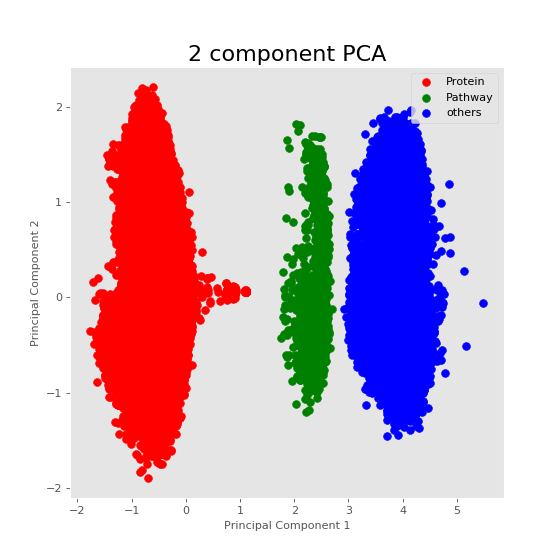

In [63]:
lp.draw_pca_of_all_nodes()

train_model_cross_validation| train_model| 128 and 1
train_model_cross_validation| train_model| X_train: 188892, X_test: 80954, y_train: 188892, y_test:80954
train_model_cross_validation| scores: [0.97612493 0.97946003 0.97506617 0.97622955 0.97670602 0.97495897
 0.97432368 0.97760601 0.97580602 0.97824015]
train_model_cross_validation| Accuracy: 0.98 (+/- 0.00)


<IPython.core.display.Javascript object>


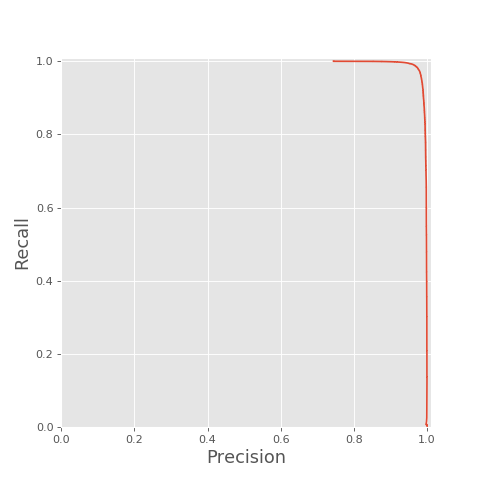

__AUC_ROC| roc_auc_lr: 0.9965693548449471


/home/abbas/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:643: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<IPython.core.display.Javascript object>


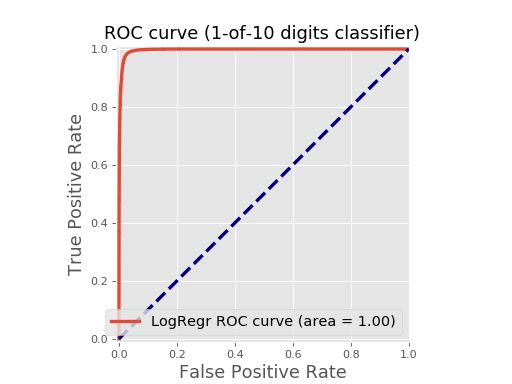

/home/abbas/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:665: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train_model_cross_validation| Accuracy of logistic regression classifier on test set: 0.98
[[39360  1098]
 [  700 39796]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     40458
           1       0.97      0.98      0.98     40496

    accuracy                           0.98     80954
   macro avg       0.98      0.98      0.98     80954
weighted avg       0.98      0.98      0.98     80954



In [64]:
lp.train_model_cross_validation('newton-cg', 'ovr', cv = 10, ver = '40-40-biased-v4_CH_ALL')

In [65]:
# lp.test_dark_kinase(False)
lp.evaluate_test_set(False)

__load_test_set: df_test_set: (35759, 6)
__get_test_set_emb| test set emb list : 35759 with 0 number of errors.
__prepare_test_set_emb| list of test set prepared 35759
__test| 35759 and 35759
__test| 128 and 1
[[    0     0]
 [ 5850 29909]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.84      0.91     35759

    accuracy                           0.84     35759
   macro avg       0.50      0.42      0.46     35759
weighted avg       1.00      0.84      0.91     35759



/home/abbas/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [66]:
lp.test_dark_kinase(False)

__get_dark_kinase_emb| dark emb list from df_dark_hasPathway: 136
__prepare_dark_emb| list of dark prepared 136
__test| 136 and 136
__test| 128 and 1
[[  0   0]
 [ 33 103]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.76      0.86       136

    accuracy                           0.76       136
   macro avg       0.50      0.38      0.43       136
weighted avg       1.00      0.76      0.86       136



/home/abbas/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [58]:
df_nodes = pd.read_csv('data/df_nodes_cc.csv')
df_nodes[df_nodes['id'] == 204131]
df_merge_cc = pd.read_csv('data/df_merge_cc.csv')
df_train = pd.read_csv('data/df_merge_cc_train.csv')
df_merge_cc[df_merge_cc['t'] == '111931']
emb = lp.get__emb_dict()
c = 0
for i in df_merge_cc[df_merge_cc['t'] == '111931']['h_id'].unique():
    pro = df_nodes.loc[df_nodes['id'] == i, 'name'].values[0]
    count = df_train.loc[df_train['h'] == pro].shape[0]
    print(i, pro, count)
    
    if str(i) in emb:
        c+=1
c, '204131' in emb

146711 P16220 163
208142 P17612 2345
11330 P22612 2083
65662 P22694 16
15580 P51817 1861


(5, False)

### Statistical Significance

In [ ]:
# lst_sig = lp.statistical_significance_for_each_prediction(path_org_data, gene_map_file, reactome_map_file, 
#                                                 n_iter = 6, p = 0.5, alternative='two-sided', pvalue = 0.05)

In [ ]:
# arr_sig = np.array(lst_sig)

In [ ]:
# list(lst_sig).count(1), len(lst_sig)

In [ ]:
# d_ppic_pred = lp.get__dict_ppid_pred()
# print('d_ppic_pred: {}'.format(len(d_ppic_pred)))

# set_count = set()
# for k in d_ppic_pred:
#     if 1 in d_ppic_pred[k]:
#         count_1 = d_ppic_pred[k].count(1)
#         set_count.add(count_1)
# set_count

#### End Statistical Significance

In [25]:
path_org_data, gene_map_file, reactome_map_file = 'data/original/','Protein_Kinase_List_v3.txt','UniProt2Reactome_All_Levels.txt'

In [26]:
df_raw_prediction, list_prediction_all = lp.predict_dark_pathway('df_merge_cc.csv',path_org_data, gene_map_file, reactome_map_file)

__get_df_dark_node| list_dark: 160, df_dark_node shape: 156, df_dark_node name unique: 156 
predict_dark_pathway| prediction process for train-test split...
predict_dark_pathway| df_all_merge: (2886875, 6)
predict_dark_pathway| df_p: (170965, 6)
predict_dark_pathway| list_unique_pathway: 1584
predict_dark_pathway| df_pathway_node: 1584
__generate_reactome_to_name| df_reactome_short: (20996, 2)
__generate_reactome_to_name| dict_reactome_ALL_name: 2500, dict_reactome_HSA_name: 2309
__generate_reactome_to_name| mapping file reactometoid.txt is saved.
predict_dark_pathway| dict_reactome_ALL_name: 2500, dict_reactome_HSA_name: 2309
predict_dark_pathway| list_HSA: 2309, list_HSA_code: 2309
predict_dark_pathway| df_human_pathway_nodes: (1506, 2)
predict_dark_pathway| Done prediction process for train-test split
__predict_dark_pathway| df_dark_node: 156, self.__df_human_pathway_node: 1506
__predict_dark_pathway| missing protein: 93, missing pathways: 1134
__predict_dark_pathway| possitive pred

In [27]:
df_raw_prediction.head(2)

,protein,pathway,probability
0,Q5VT25,444257,0.999999
1,Q5VT25,442742,0.999998


In [28]:
df_prediction_with_name = lp.generating_full_prediction_list()

# Protein_Kinase_List_v3.txt or uniprotIds.csv

generating_full_prediction_list| df_prediction_raw_unkowns: (3305, 3)
__generate_uniprot_to_kinbase| df_uniprot_to_gene: (545, 3)
__generate_uniprot_to_kinbase| unique_uniprot_from_uniprotIds : 545
__generate_uniprot_to_kinbase| dict_uniprot_to_genes: 545
__generate_reactome_to_name| df_reactome_short: (20996, 2)
__generate_reactome_to_name| dict_reactome_ALL_name: 2500, dict_reactome_HSA_name: 2309
__generate_reactome_to_name| mapping file reactometoid.txt is saved.
generating_full_prediction_list| df_prediction_with_names: (3305, 5)
generating_full_prediction_list| prediction with names saved.


In [29]:
df_prediction_with_name.head(10)

,uniprot,protein_name,pathway_id,pathway_name,score
0,Q5VT25,{CDC42BPA},444257,{RSK activation},0.999999
1,Q5VT25,{CDC42BPA},442742,{CREB1 phosphorylation through NMDA receptor-m...,0.999998
2,O14986,{PIP5K1B},8847453,{Synthesis of PIPs in the nucleus},0.999997
3,Q5VT25,{CDC42BPA},8986944,{Transcriptional Regulation by MECP2},0.999993
4,Q9UQ88,{CDK11A},380320,{Recruitment of NuMA to mitotic centrosomes},0.999986
5,Q8TBX8,{PIP4K2C},201688,{WNT mediated activation of DVL},0.999983
6,Q5VT25,{CDC42BPA},9634638,{Estrogen-dependent nuclear events downstream ...,0.999982
7,Q04759,{PRKCQ},8986944,{Transcriptional Regulation by MECP2},0.999981
8,P21127,{CDK11B},380320,{Recruitment of NuMA to mitotic centrosomes},0.999981
9,Q9Y2H1,{STK38L},442742,{CREB1 phosphorylation through NMDA receptor-m...,0.999979


In [10]:
ths = lp.thresholds
fpr_lr, tpr_lr, th = ths
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [11]:
ls = list(zip(fpr_lr,tpr_lr))
ls[:1]

[(0.0, 0.0)]

In [12]:
i = np.arange(len(tpr_lr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr_lr-(1-fpr_lr), index=i), 'threshold' : pd.Series(th, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

list(roc_t['threshold'])

[0.26679083614537547]

In [13]:
roc_t


,tf,threshold
1611,0.000046,0.266791


# The rewire process 

In [ ]:
lpr = LinkPrediction('data/', 'df_merge_rew_train-NoSplit_1.csv', 'df_nodes_cc.csv', 'df_relations.csv'
                    , 'emb-pro-x-pro-path-100-40-graphpattern2vec-biased-v2-rewire-merge_rew_train_NoSplit_1', 'light_kinase'
                    , 'dark_kinase','df_merge_rew_test-NoSplit_1.csv', 'results/rewire1/')

In [ ]:
lpr.draw_pca_of_all_nodes()

In [ ]:
lpr.train_model_cross_validation('newton-cg', 'ovr', cv = 2, ver = '_100_40_cv2_biased-v2-rewire-NoSplit_1.png')

In [ ]:
# lp.test_dark_kinase(False)
lpr.evaluate_test_set(False)

In [ ]:
lpr.test_dark_kinase(False)

In [ ]:
path_org_data, gene_map_file, reactome_map_file = 'data/original/','Protein_Kinase_List_v3.txt','UniProt2Reactome_All_Levels.txt'

In [ ]:
df_raw_prediction, list_prediction_all = lpr.predict_dark_pathway('df_merge_cc.csv',path_org_data, gene_map_file, reactome_map_file)

# The protien in Kannan interest

In [ ]:
df_pred_Q96C45 = df_prediction_with_name[df_prediction_with_name['uniprot'] == 'Q96C45']
print('df_pred_Q96C45: {}'.format(df_pred_Q96C45.shape))

df_pred_Q96C45_top80prec = df_pred_Q96C45[df_pred_Q96C45['score'] > 0.80]
print('df_pred_Q96C45_top80prec: {}'.format(df_pred_Q96C45_top80prec.shape))

df_pred_Q96C45_top80prec.to_csv('data/df_pred_Q96C45_top80prec.csv')

df_pred_Q96C45_top80prec.head(2)

In [ ]:
# check 
# df_pred_Q96C45[df_pred_Q96C45['pathway_id'] == '5610783']

In [ ]:
tudor_list = ['O15021', 'O43930', 'P0C264', 'P51957', 'Q00532', 'Q504Y2', 'Q56UN5', 'Q6A1A2', 'Q6P3R8', 'Q6ZMQ8', 'Q6ZN16', 
             'Q86YV5', 'Q8IVW4', 'Q8IWB6', 'Q8IZE3', 'Q8N2I9', 'Q8N568', 'Q8NE28', 'Q8TDR2', 'Q96C45', 'Q96LW2', 'Q96PN8',
             'Q96QS6', 'Q9C098', 'Q9NSY0', 'Q9NY57']
print('tudor_list: {}'.format(len(tudor_list)))

df_tudor = df_prediction_with_name[df_prediction_with_name['uniprot'].isin(tudor_list)]
print('df_tudor: {}'.format(df_tudor.shape))

df_tudor.to_csv('data/tudor_list_prediction_by_FixedII.csv')
print('df_tudor full is saved.')

df_tudor_g = df_tudor.groupby('uniprot')['pathway_name'].count().reset_index(name = 'count')
print('df_tudor_g: {}'.format(df_tudor_g.shape))

df_tudor_top80pred = df_tudor[df_tudor['score'] > 0.80]
print('df_tudor_top80pred: {}'.format(df_tudor_top80pred.shape))

df_tudor_top80pred.to_csv('data/tudor_list_prediction_by_FixedII_biased-v2-score80.csv')
print('df_tudor_top80pred full is saved.')

In [ ]:
# check common predictions
df_18 = df_prediction_with_name[df_prediction_with_name['uniprot'] == 'Q07002']
df_19 = df_prediction_with_name[df_prediction_with_name['uniprot'] == 'Q9BWU1']

list_18 = (list(df_18['pathway_name']))
list_19 = (list(df_19['pathway_name']))

# df_18.shape, df_19.shape
common_18_19 = [i for i in list_18 if i in list_19]
len(common_18_19)

# sample: missing protein id form emb

a = [100518, 51760, 168228,32097, 423]
df_n = lp.get__df_nodes()
df_n[df_n['id'].isin(a)]

# 423,    Q9Y463, DYRK1B, Dual specificity tyrosine-phosphorylation-regulated kinase 1B [dark]
# 32097,  O15021, MAST4,  Microtubule-associated serine/threonine-protein kinase 4      [dark]
# 51760,  Q6P0Q8, MAST2, Microtubule-associated serine/threonine-protein kinase 2       [dark]
# 100518, Q9BXA6, TSSK6, Testis-specific serine/threonine-protein kinase 6              [dark]
# 168228, Q96QS6, PSKH2, Serine/threonine-protein kinase H2                             [dark]

# we have 156 dark kinase node, 39 of them are missing

# Check how many predictions are for Human Pathway vs Non Human

In [ ]:
# predictions over R-HSA 
def hist_array(a, title):
    
    plt.figure(figsize=(5, 5))
    print('min: {}, max: {}'.format(np.min(a), np.max(a)))
    _ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
    plt.title(title)

    plt.show()
    
def generate_reactome_to_name( path_org_data, file_name):
        df_reactome = pd.read_csv(path_org_data + file_name, sep='\t', names=['id', 'identifier', 'name', 'a', 'b', 'c'])
        df_reactome_short = df_reactome[['identifier', 'a']].drop_duplicates(keep='first')
        print('__generate_reactome_to_name| df_reactome_short: {}'.format(df_reactome_short.shape))
        
        dict_reactome_HSA_name = dict()
        dict_reactome_ALL_name = dict()
        for i in df_reactome_short.itertuples():
            full_id = i[1]
            name    = i[2]
            if 'R-HSA' in full_id:
                if full_id not in dict_reactome_HSA_name:
                    dict_reactome_HSA_name[full_id] = set()
                dict_reactome_HSA_name[full_id].add(name)
            short_id = full_id[full_id.rindex('-')+1:]
            if short_id not in dict_reactome_ALL_name:
                dict_reactome_ALL_name[short_id] = set()                
            dict_reactome_ALL_name[short_id].add(name)
            
        print('__generate_reactome_to_name| dict_reactome_ALL_name: {}, dict_reactome_HSA_name: {}'.format(
            len(dict_reactome_ALL_name), len(dict_reactome_HSA_name)))
        
        
        
        return dict_reactome_ALL_name, dict_reactome_HSA_name

In [ ]:
a, d  = generate_reactome_to_name('data/original/', 'UniProt2Reactome_All_Levels.txt')
k = [i[i.rindex('-')+1:] for i in d.keys()]
df_non_HSA = df_prediction_with_name[~df_prediction_with_name['pathway_id'].isin(k)]
df_HSA = df_prediction_with_name[df_prediction_with_name['pathway_id'].isin(k)]
print('df_HSA: {}, df_non_HSA: {}'.format(df_HSA.shape, df_non_HSA.shape))
arr_n_hsa = np.array(df_non_HSA['score'])
arr_hsa = np.array(df_HSA['score'])
arr_n_hsa[:2], arr_hsa[:2]

In [ ]:
hist_array(arr_hsa, 'Human')

In [ ]:
# hist_array(arr_n_hsa, 'None Human')

# Check the trained model for other pairs of nodes

In [ ]:
df_m = lp.get__df_merge()
df_n = lp.get__df_nodes()
em = lp.get__emb_dict()
uniq_pathway = lp.get__list_unique_pathway()
model = lp.get_the_model()
# ['hasPathway', 'hasFunctionalDomain', 'interact', 'hasPTM', 'hasCellularComponent', 'hasMolecularFunction', 'hasBiologicalProcess']


In [ ]:
def get_nodes_by_relation(df_m,df_n, r, emb, h_list, model):
    print('h_list: {}'.format(len(h_list)))
    
    list_nodeType_id = list(df_m.loc[df_m['r'] == r, 't_id'].unique())
    print('list_nodeType_id: {}'.format(len(list_nodeType_id)))
    
    df_nodes_type = df_n[df_n['id'].isin(list_nodeType_id)]
    print('df_nodes_type: {}'.format(df_nodes_type.shape))
    
    print(list_nodeType_id[:3])
    
    emb_node_type = { i:emb[str(i)] for i in list_nodeType_id if str(i) in emb.keys() }
    print('emb_node_type: {}'.format(len(emb_node_type)))
    
    emb_h_list = { i:emb[str(i)] for i in h_list if str(i) in emb.keys() }
    print('emb_h_list: {}'.format(len(emb_h_list)))
    
    predicted_true_count = 0
    predicted_false_count = 0
    result = list()
    
    lst_h_keys    = list(emb_h_list.keys())
    lst_node_keys = list(emb_node_type.keys())
    
    for i in tqdm(range(2000)):
        h = random.choice(lst_h_keys)
        t = random.choice(lst_node_keys)
        
        e = np.multiply(emb_h_list[h], emb_node_type[t])
        
        prediction = model.predict([e])
        prob       = model.predict_proba([e])

        if (prediction ==1):
            result.append([prob])
            predicted_true_count += 1
        else:
            predicted_false_count+=1
            
    return result
    
lst = get_nodes_by_relation(df_m, df_n, 'hasMolecularFunction' ,em, uniq_pathway, model)
len(lst)

In [ ]:
df_p = pd.read_csv('data/prediction_with_names_emb-pro-x-pro-path-100-40-graphpattern2vec-HL-Path-Biased-fixedcsv')
df_p.loc[df_p['uniprot'] == 'Q96C45',:]

In [ ]:
df_m = pd.read_csv('data/df_merge_cc.csv')
df_m.head(2)

In [ ]:
# df_m.loc[df_m['h'] == 'Q96C45','r'].unique() #'interact', 'hasMolecularFunction', 'hasBiologicalProcess'
# df_m[(df_m['h'] == 'Q96C45') & (df_m['r'] == 'hasPathway')]
df_Q9  = df_m[(df_m['h'] == 'Q96C45') & (df_m['r'] == 'interact')]
lst_Q9 = list(df_Q9['t'].unique())
len(lst_Q9)

In [ ]:
df_Q9_ppi_pathways = df_m.loc[(df_m['h'].isin(lst_Q9) )]
lst_Q9_ppi_pathways = list(df_Q9_ppi_pathways['t_id'].unique())

In [ ]:
len(lst_Q9_ppi_pathways)

In [ ]:
df_n = lp.get__df_nodes_cc()

In [ ]:
mcols = ['h','t','r','h_id','t_id', 'r_id']
dtype = {mcols[0]:object, mcols[1]:object, mcols[2]:object, mcols[3]:int, mcols[4]:int, mcols[5]:int}
df_all_merge = pd.read_csv('data/df_merge_cc.csv' ,dtype=dtype)
print('predict_dark_pathway| df_all_merge: {}'.format(df_all_merge.shape))

df_p = df_all_merge[df_all_merge[mcols[2]] == 'hasPathway']
print('predict_dark_pathway| df_p: {}'.format(df_p.shape))


list_unique_pathway_str = list(df_p[mcols[1]].unique())
# list_unique_pathway = [ for i in list_unique_pathway_str]

print('predict_dark_pathway| list_unique_pathway: {}'.format(len(list_unique_pathway)))


df_pathway_node = df_n[df_n['name'].isin(list_unique_pathway_str)]
df_pathway_node.shape

In [ ]:
set_nodes = set(df_n['name'].unique())
len(set_nodes)


In [ ]:
c=0
for i in df_p.itertuples():
    t = i[2]
    if t in set_nodes:
        c+=1

In [ ]:
c